In [1]:
# Import the required modules
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import IPython.display

import cv2
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# UTILITY FUNCTIONS

In [3]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, fmt='jpeg'):
    a = cv2.resize(a, (600 , 300))
    if len(a.shape) is 3:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    if not ret:
        raise KeyboardInterrupt()
    
    #flip image for natural viewing
    #frame = cv2.flip(frame, 1)
    
    return frame

In [5]:
# PROCESS FUNCTIONS

In [6]:
def generate_LUT(gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    def adjust_gamma(image):
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)
    return adjust_gamma

In [7]:
def DoG(frame, s=1, stride=0):
    #run a 5x5 gaussian blur then a 3x3 gaussian blr
    sB = (s+1+stride)*2+1
    sS = (s)*2+1
    blurB = cv2.GaussianBlur(frame,(sB,sB),0)
    blurS = cv2.GaussianBlur(frame,(sS,sS),0)

    return blurB - blurS

In [8]:
def Unwarp(frame):
    pts_src = np.array([[67, 0], [63, 856], [1552, 856],[1500, 0]])
    pts_dst = np.array([[0, 0],[0, 856],[1552, 856],[1552, 0]])

    h, status = cv2.findHomography(pts_src, pts_dst)
    frame_out = cv2.warpPerspective(frame, h, (frame.shape[1],frame.shape[0]))
    return frame_out[:, 200:1400]

In [9]:
se_c = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
se_vl = np.array([[0,1,0],[0,1,0],[0,1,0]], np.ubyte)
def morhpOps(frame):
    frame_out = cv2.morphologyEx(frame, cv2.MORPH_OPEN, se_c, iterations=1)
    frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_vl, iterations=2)
    return frame_out

In [10]:
def proposeScan(frame_p, frame_in, scan_line_h, bins_count=50, bin_threshold=100):
    #Get full frame scan line
    scan_line = frame_p[scan_line_h,:]

    # Find first peaks from center
    # Find peaks
    bin_width = round(len(scan_line)/bins_count)
    scan_bins = sum(split(scan_line, bins_count), 1) # Grouped in 50 bins
    scan_bins_peaks = where(scan_bins>bin_threshold)[0]
    # Break peaks indexes to left an right from center
    # And get peaks nearest to center
    center_bin = round(bins_count/2)
    left_peak_predicate = scan_bins_peaks <= center_bin
    right_peak_predicate = scan_bins_peaks > center_bin
    if not any(left_peak_predicate) or not any(right_peak_predicate):
        return False, None, None
    left_peak = int(scan_bins_peaks[left_peak_predicate][-1]*bin_width-bin_width/2)
    right_peak = int(scan_bins_peaks[right_peak_predicate][0]*bin_width+bin_width/2)

    # Calculate various conditions
    cavity_width = right_peak-left_peak
    cavity_weight = sum(frame_p[scan_line_h,left_peak:right_peak])
    
    if cavity_width > 800:
        return True, left_peak, right_peak
    else:
        return False, None, None

In [39]:
def generate_process():
    adjust_gamma = generate_LUT(5)
    scan_line_h = 720
    found_plate = False
    lost_plate_frames = 0
    llp, lrp = None, None
    def process(frame_in):
        nonlocal found_plate
        nonlocal lost_plate_frames
        nonlocal llp, lrp

        frame_out = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
        frame_out = cv2.equalizeHist(frame_out)
        frame_out = adjust_gamma(frame_out)
        frame_out = DoG(frame_out, 1, 1)
        frame_out = morhpOps(frame_out)
        frame_out = Unwarp(frame_out)
        ret, lp, rp = proposeScan(frame_out, frame_in, scan_line_h)
        if ret:
            llp, lrp = lp, rp
            lost_plate_frames = 0
            if not found_plate:
                found_plate = True
        elif found_plate and lost_plate_frames < 5:
            lp, rp = llp, lrp
            lost_plate_frames += 1
        else:
            found_plate = False
            lost_plate_frames = 0
            llp, lrp = None, None
        if(found_plate):
            # Extract proposed line
            # Kartashev: in grayscale for simplier interpolation
            frame_gray = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
            scanned_line = frame_gray[scan_line_h,lp:rp]
            return frame_out, scanned_line
        else:
            return frame_out, None
    return process

In [61]:
# Work area

In [88]:
input_file_path = 'bandicam 2018-10-24 10-51-31-769.mp4'
vid = cv2.VideoCapture(input_file_path)

In [89]:
# Seek needed frame
vid.set(cv2.CAP_PROP_POS_FRAMES,470)
frame = get_frame(vid)

In [90]:
#Kartashev: interpolation and gluing
from scipy.interpolate import UnivariateSpline

def glue(sum_plate, line):
    old_indices = np.arange(0, len(line))
    #new_length = np.shape(line)[0] if np.shape(line)[0] > np.shape(sum_plate)[0] else np.shape(sum_plate)[0]
    new_length = np.shape(sum_plate)[1]
    new_indices = np.linspace(0, len(line)-1, new_length)
    spl = UnivariateSpline(old_indices, line, k=3, s=0)
    new_line = spl(new_indices)
    return np.vstack((sum_plate, [new_line]))
sum_plate = None


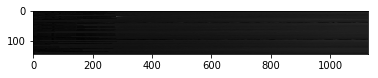

In [91]:
process = generate_process()
frames_to_play = 200
plate = None
try:
    
    
    while(frames_to_play):
        t1 = time.time()
        
        # Capture frame-by-frame
        frame = get_frame(vid)
        frames_to_play -= 1

        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame_p, line = process(frame)
        if line is not None and plate is None:
            print('plate have started')
            plate = True
        if line is not None and plate is not None:
            #пока отображаем только последнюю. И в Grayscale, так проще делать интерполяцию
            if sum_plate is None:
                sum_plate = [np.empty(np.shape(line))]
            sum_plate = glue(sum_plate, line)
            print(np.shape(sum_plate))
            print('appended plate')
        if line is None and plate is not None:
            print('plate has ended')
            plate = None
        if line is None and plate is None:
            print('No plate')
        showarray(frame_p)
        if line is not None:
            pass
            #plot(line)
        t2 = time.time()
        #time.sleep(0.3)

        print('%f FPS' % (1/(t2-t1+1e-07)))
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
    print('Stream stopped')
plt.imshow(sum_plate, cmap='gray')

In [84]:
# TEST